
<h1><center>Trends In Forest Recovery After Stand Replacing Disturbance: A Spectrotemporal Evaluation Of Productivity In Southeastern Pine Forests</center></h1>

<h4><center> Daniel J. Putnam </center></h4>

<center> For partial fulfillment of the reqiurements for the Master of Science degree </center>
<center> College of Natural Resources and Environment </center>
<center> Virginia Polytechnic Institute and State University </center>


## Analysis Preperation

### _Libraries_

In [1]:
import geemap
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from palettable.colorbrewer.diverging import RdYlGn_11 as NDVIpalette
from palettable.colorbrewer.sequential import YlOrRd_9 as LCMSpalette
ee.Initialize()

### _Imports_

In [2]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") # landsat 5
LS7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") # landsat 7
LS8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") # landsat 8
LCMS = ee.ImageCollection("USFS/GTAC/LCMS/v2020-5") # Landcover Change Monitoring System
NLCD_col = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") # national landcover Database
STATES = ee.FeatureCollection("TIGER/2018/States") # state polygon boundaries (probably don't need anymore)
ecoRegions = ee.FeatureCollection("EPA/Ecoregions/2013/L3") # EPA Ecoregions
loblolly = ee.FeatureCollection("users/dputnam21/USFS_loblollyRange") # USFS loblolly pine range within states of interest
protectedAreas = ee.FeatureCollection("WCMC/WDPA/current/polygons")
GAP = ee.FeatureCollection("USGS/GAP/PAD-US/v20/fee")

### _Priliminary set-up_

In [3]:
# Expirementing with colorbrewer palettes
## palettes = ee.data.require('users/gena/packages:palettes') ## going to need to replace this section of code
#NDVIpalette = palettes.colorbrewer.RdYlGn[9]
#LCMSpalette = palettes.colorbrewer.YlOrRd[9]

# Creating sample date range for disturbances
startingD = ee.Date.fromYMD(1995,1,1)
endingD = ee.Date.fromYMD(2010,12,31)

### _Landsat Preprocessing_

In [4]:
# Cloud masking based on the QA band : code taken from landsat example in data catalog in EE
def LScloudMask(image):
  qa = image.select('pixel_qa')
    # removing cloud pixels if confiance is high, cloud shadow, snow
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)) \
            .Or(qa.bitwiseAnd(1 << 3)) \
            .Or(qa.bitwiseAnd(1 << 4))
  return image.updateMask(cloud.Not())

# Going to try removing the coverage overlap between LS5 and LS8 to try and fix some issues
#LS5 = LS5.filterDate(start = '1984-01-01',opt_end = ee.Date('2013-04-11'))
#LS8 = LS8.filterDate(start = ee.Date('2013-04-11'))

# Lansat 5/7 & 8 differ in their band labeling, need to select the bands I'm going to use and rename them to
# match each other before merging collections : bands I need [red,green,NIR,SWIR1,SWIR2]    
LS8BandNames = ee.List(['B4','B3','B5','B6','B7','pixel_qa'])
NewBandNames = ee.List(['B3','B2','B4','B5','B7','pixel_qa'])
LS8 = LS8.select(LS8BandNames,NewBandNames)

# Adding a function to calculate and add an NDVI band for a single image
def addNDVI(image):
  ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
  return image.addBands(ndvi)

# Adding a function to calculate and add an NBR band for a single image.
def addNBR(image):
  nbr = image.normalizedDifference(['B4', 'B7']).rename('NBR')
  return image.addBands(nbr)

# Adding a function to calculate and add an MBI band for a single image.
def addMBI(image):
  MBI = image.expression(
  "MBI = ((b('B5') - b('B7') - b('B4')) / (b('B5') + b('B7') + b('B4'))) + 0.5")
  return image.addBands(MBI)

# adding the cloud mask per generation
LS5 = LS5.map(LScloudMask)
LS7 = LS7.map(LScloudMask)
LS8 = LS8.map(LScloudMask)

# merging the landsat 5 and 7 collections
LS_stack = LS5.merge(LS8)
LS_stack = LS_stack.merge(LS7)

# data reduction on the image stack
LS_stack = LS_stack.filterBounds(loblolly)

# Adding the indices to the filtered combined Landsat collection
LS_stack_wVI = LS_stack.map(addNDVI)
LS_stack_wVI = LS_stack_wVI.map(addNBR)
LS_stack_wVI = LS_stack_wVI.map(addMBI)

---

## Stand Identification Methods

### _Landcover/Landuse Mask_

In [5]:
# New NLCD/LCMS method
# retrieve NLCD for each year
NLCD_2001 = NLCD_col.filter(ee.Filter.eq('system:index', '2001')).first().select("landcover")
NLCD_2004 = NLCD_col.filter(ee.Filter.eq('system:index', '2004')).first().select("landcover")
NLCD_2006 = NLCD_col.filter(ee.Filter.eq('system:index', '2006')).first().select("landcover")
NLCD_2008 = NLCD_col.filter(ee.Filter.eq('system:index', '2008')).first().select("landcover")
NLCD_2011 = NLCD_col.filter(ee.Filter.eq('system:index', '2011')).first().select("landcover")
NLCD_2013 = NLCD_col.filter(ee.Filter.eq('system:index', '2013')).first().select("landcover")
NLCD_2016 = NLCD_col.filter(ee.Filter.eq('system:index', '2016')).first().select("landcover")
NLCD_2019 = NLCD_col.filter(ee.Filter.eq('system:index', '2019')).first().select("landcover")

# combine NLCD to image collection
NLCDlandcover_col = ee.ImageCollection(ee.List([NLCD_2001,NLCD_2004,NLCD_2006,NLCD_2008,NLCD_2011,NLCD_2013,NLCD_2016,NLCD_2019]))

# Function to remap NLCD classes of interest for conditional layer
def remapNLCD(image):
    image = ee.Image(image)
    image = image.updateMask(ee.Image.constant(42).Or(ee.Image.constant(52)))
    image = image.remap(ee.List([42,52]),ee.List([10,1]),defaultValue = None)
    return image

# Layer containing the summed values of pixels across the collection after remapping
NLCDclassSum = NLCDlandcover_col.map(remapNLCD).reduce(ee.Reducer.sum())
NLCDMask = NLCDclassSum.remap(ee.List([53,62,71,80]),ee.List([1,1,1,1]), defaultValue = None)

# retrieve LCMS landuse classification
LCMSlanduseCol = LCMS.select("Land_Use")

# A function to select only forest landuse class
def remapLCMS(image):
    image = ee.Image(image)
    onlyForest = image.remap([3],[1], defaultValue = None)
    return onlyForest

LCMSlanduseSum = LCMSlanduseCol.map(remapLCMS).reduce(ee.Reducer.sum())

# # combining the two layers into a mask
landCoverMask = NLCDMask.updateMask(LCMSlanduseSum.gte(35))
landCoverMask = landCoverMask.clip(loblolly) # clip mask to study boundaries for better loading

### _LCMS Fast change method_

In [6]:
# Using the LCMS Change metric to identify harvest areas in contrast to the max VI method
# Filtering LCMS for the region and timeframe
LCMSchange = LCMS.select('Change_Raw_Probability_Fast_Loss')
LCMSchange = LCMSchange.filterDate(startingD,endingD)

def LCMSchangeSelection(image):
    image = ee.Image(image)
    minConfidence = 70
    gtePercent = image.gte(ee.Image.constant(minConfidence))
    gtePercent = gtePercent.updateMask(gtePercent.eq(1))
    gtePercent = gtePercent.set({'year':image.date().get('year')})
    outImage = gtePercent.updateMask(landCoverMask).rename('remapped')
    return outImage

# applying the function to the LCMS
FC_stack = LCMSchange.map(LCMSchangeSelection)

### _Connected Pixel (Min stand size) mask_

In [7]:
# function to apply a connected pixel mask to the input image
def conectPixls(InImage,minArea,maxPixels):
    pixelCount = InImage.connectedPixelCount(maxPixels,False)
    minPixelCount = ee.Image(minArea).divide(ee.Image.pixelArea())
    outImage = InImage.updateMask(pixelCount.gte(minPixelCount))
    return outImage

# a function to be mapped accross an image collection and annually apply the connected pixels mask, also creates an
# additional band to store the year of disturbance for each pixel
def annualConectPixls(image):
    conectPixlsMasked = conectPixls(image,49500,1024) # minimum stand size of 5 hectares, maximum of 92 (tool limit)
    imgYear = image.get('year')
    imgYearBand = ee.Image.constant(imgYear).uint16().rename('ChangeY')
    imgYearBand = imgYearBand.updateMask(conectPixlsMasked)
    return conectPixlsMasked.addBands(imgYearBand)

FC_final = FC_stack.map(annualConectPixls)

In [8]:
# creating the summary images
FC_final_changeN = FC_final.select('remapped').reduce(ee.Reducer.sum())
FC_final_1stYear = FC_final.select('ChangeY').reduce(ee.Reducer.min())

---

## Automatic Stand Selection Method

### _Creating Sampling Areas Using Ecoregions_

In [9]:
# Limit ecoregions by overlap with loblolly range
loblollyEcoRegions = ecoRegions.filterBounds(loblolly)

# Function to convert the ecoregion code to an integer value
def convertPropertyToBand(feat):
    feat = ee.Feature(feat)
    prop = feat.get('us_l3code')
    propInt = ee.Number.parse(prop).toInt()
    feat = feat.set({'numericL3ecocode':propInt})
    return feat
loblollyEcoRegions = loblollyEcoRegions.map(convertPropertyToBand)

# Need to convert ecoregion feature collection and the property to integer in order for it to be used 
#     as the 'classBand' in the stratifiedSample fucntion
ecoregionImage = ee.Image(loblollyEcoRegions.reduceToImage(['numericL3ecocode'],ee.Reducer.first()))
ecoregionImage = ecoregionImage.cast({'first':'int8'})
ecoregionImage = ecoregionImage.clipToCollection(loblolly)

# An image representing pixels that are fast change and meet the landcover reqiurements
potentialSamples = ee.Image.toUint8(FC_final_changeN.updateMask(FC_final_changeN.lte(2)).remap([1,2],[1,1],defaultValue = 0)).rename('remapped_sum')

# Adding ecoregion code as band to potential sample pixels
potentialSamples = potentialSamples.addBands(ecoregionImage.select('first').rename('numericL3ecocode'))

In [10]:
# Edge avoidence
PS_connectedPixelCount = potentialSamples.reduceNeighborhood(ee.Reducer.count(),
                                                             ee.Kernel.plus(1, 'pixels', False, 1),
                                                             'mask',
                                                             True
                                                            )
potentialSamples2 = potentialSamples.updateMask(PS_connectedPixelCount.gte(5))

### _Creating Random Sample Points_

In [11]:
# Going to try just using the export table function to drive
samplePoints = potentialSamples.stratifiedSample(numPoints = 50,
                                                 region = loblolly,
                                                 classBand = 'numericL3ecocode',
                                                 scale = 30,
                                                 seed = 5,
                                                 dropNulls = True,
                                                 geometries = True,
                                                 )

### _Imports/Exports of Created Data_

In [12]:
# Exporting the points created in the above cell to google drive (only way they will finish processing)
# The export process will take about 15 minutes to complete
#geemap.ee_export_vector_to_drive(samplePoints, 'stratifiedSamplePoints', 'EarthEngine_Exports', file_format='shp', selectors=None)

In [13]:
# # Importing the points created in the above cell
# samplePoints = ee.FeatureCollection('users/dputnam21/stratifiedSamplePoints_03022022')

In [20]:
# Importing points created in arcpro
samplePoints = ee.FeatureCollection('users/dputnam21/revisedSamplePoints2')

In [15]:
# Exporting to google drive the NLCD/LCMS masked LCMS fast change summary layer
# geemap.ee_export_image_to_drive(potentialSamples2.select('remapped_sum_count'), description='revisedPotentialSamples',region = loblolly.geometry(), folder='EarthEngine_Exports', scale=30)

---

### Displaying images on the map

In [21]:
# LCMS landcover palette
LCMSlcPalette = ['efff6b','ff2ff8','1b9d0c','97ffff','a1a1a1','c2b34a','1B1716']

Map = geemap.Map()
Map.centerObject(loblolly,7)

# This is the bottom of the layer order

# Map.addLayer(protectedAreas)
# Map.addLayer(GAP)
Map.addLayer(ecoregionImage.select('first'), vis_params = {'palette': LCMSlcPalette, 'min': 45, 'max':75}, name = 'Ecoregion Code Image')
Map.addLayer(landCoverMask, vis_params = {'palette': ['00441b'],'min':1,'max':1}, name = 'new landcover mask', shown = False)
Map.addLayer(FC_final_changeN,{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':5},'LCMS Fast Change Count',False)
Map.addLayer(FC_final_1stYear,{'palette':['edf8b1','7fcdbb','2c7fb8'],'min' : 1995, 'max' : 2010},'LCMS Fast Change Year',False)
Map.addLayer(samplePoints,{'color':'red'}, name = 'Stratified Random Samples')
Map.addLayer(potentialSamples2.select('remapped_sum'),{'palette':['fee0d2','fc9272','de2d26'],'min':0,'max':1}, name = 'Potential Samples 2', shown = False)
# Map.addLayer(NLCDclassSum,vis_params = {'palette':['edf8e9','bae4b3','74c476','31a354','006d2c'],'min':0,'max':80})
# Map.addLayer(ee.Feature(ee.Geometry.Point([-82.1455878,33.6141944])),{'color':'blue'})

# This is the top of the layer order

# potentialSamples2.select('remapped_sum')

Map.addLayerControl()
Map

Map(center=[33.55547594326177, -83.81053005836175], controls=(WidgetControl(options=['position', 'transparent_…

### Export of stand attributes

In [17]:
# adding unique ID to each point

# Adding environmental variables as attributes for each stand


### New compositing method

In [22]:
# enter analysis parameters
compositeMonthN = 11
outputIndex = 'NBR'
compositeStat = 'median'

# prep for function
chart_VI = LS_stack_wVI.filter(ee.Filter.calendarRange(compositeMonthN,compositeMonthN,'month'));

years = ee.List.sequence(1984, 2020)

In [23]:
from datetime import datetime

start = datetime.now() # figuring out how long this takes to run

def perFeatureValueExtraction(index,comMonth,vegIndex,comStat) :
    
    aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('UniqueID', index)).first())
    inFeature = aFeature.geometry()

    local_chart_VI = chart_VI.filterBounds(inFeature)

    # A function to be mapped over a feature colllection, extracts 37 index values for each feature, returns them as a
    def seasonalReduction_extraction (y):
        filteredColl = local_chart_VI.filter(ee.Filter.calendarRange(y, y, 'year'))
        singleImage = filteredColl.select(['NDVI','NBR','MBI']).reduce(ee.Reducer.median()) ## CHANGE COMPOSITE STAT HERE ###
        outputImage = singleImage.set('system:time_start', ee.Date.fromYMD(y,comMonth, 1).millis())
        valDict = outputImage.reduceRegion(reducer = ee.Reducer.mean(), geometry = inFeature, scale = 30)
        NBRval = ee.Number(valDict.get(ee.String(vegIndex+'_'+compositeStat),defaultValue = 0.0))
        return ee.List([NBRval, 0.0]).reduce(ee.Reducer.firstNonNull())

    outputList = ee.List(years.map(seasonalReduction_extraction,False)).getInfo()
    return outputList

# calling the function
NumPlots = samplePoints.size().getInfo()
ListOfValLists = []

for index in range(NumPlots) :
    #aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('system:index', 0)).first())
    aList = perFeatureValueExtraction(index,compositeMonthN,outputIndex,compositeStat)
    ListOfValLists.append(aList)
    
end = datetime.now() # effectively ending the timer
duration = end - start

# nicely printing the ellapsed time
timeList = str(duration).split(':')
print('The time elapsed during this execution of this operation was :','\n',
     timeList[0],'Hour(s)','\n',
     timeList[1],'Minute(s)','\n',
      'and',round(float(timeList[2]),ndigits = 0),'Seconds'
     )

# nicely displaying the raw data
standNum = 0
for alist in ListOfValLists :
    print('Stand',standNum,'\n',alist,'\n',('-'*124))
    standNum += 1

The time elapsed during this execution of this operation was : 
 0 Hour(s) 
 28 Minute(s) 
 and 21.0 Seconds
Stand 0 
 [0, 0, 0, 0, 0.5022222399711609, 0, 0.5854717493057251, 0, 0, 0, 0.5639358758926392, 0.2403433471918106, 0.14550724625587463, 0.1582910716533661, 0.19201120734214783, 0.31786373257637024, 0.4569610059261322, 0.5288822054862976, 0.5380348563194275, 0.686994194984436, 0.7030380964279175, 0.7332808971405029, 0.7182971239089966, 0.6371152997016907, 0.6976743936538696, 0.6869315505027771, 0.6844497919082642, 0.7257038950920105, 0, 0.7406942844390869, 0.5572249293327332, 0.509109377861023, 0.6310924291610718, 0.6042047739028931, 0.6367924809455872, 0.6475907564163208, 0.4668411910533905] 
 ----------------------------------------------------------------------------------------------------------------------------
Stand 1 
 [0, 0, 0, 0, 0.3456743359565735, 0, 0, 0, 0, 0.3318535089492798, 0.43321719765663147, 0.47340425848960876, 0.061249613761901855, 0.07110682874917984, 0.134

In [28]:
# creating arrays for rows and columns of the table
stand_nums = range(0,samplePoints.size().getInfo())
imageYears = years.getInfo()
numYears = years.size().getInfo()

# client side replacement of null value (0.0) with null object
NDVIvals = ListOfValLists
for i in range(0,len(NDVIvals)):
    for i2 in range(0,numYears) :
        if NDVIvals[i][i2] == 0 :
            NDVIvals[i][i2] = None

In [32]:
# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

NDVItsDF = pd.DataFrame(index = stand_nums, columns = imageYears)
valIndex = 0
for r in range(0,len(stand_nums)):
    for c in range(0,len(imageYears)):
        NDVItsDF.iloc[r,c] = NDVIvals[r][c]
        valIndex += 1
        
for col in NDVItsDF:
    NDVItsDF[col] = pd.to_numeric(NDVItsDF[col], errors='coerce')
NDVItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,NaN,NaN,NaN,NaN,0.502222,NaN,0.585472,NaN,NaN,NaN,0.563936,0.240343,0.145507,0.158291,0.192011,0.317864,0.456961,0.528882,0.538035,0.686994,0.703038,0.733281,0.718297,0.637115,0.697674,0.686932,0.684450,0.725704,NaN,0.740694,0.557225,0.509109,0.631092,0.604205,0.636792,0.647591,0.466841
1,NaN,NaN,NaN,NaN,0.345674,NaN,NaN,NaN,NaN,0.331854,0.433217,0.473404,0.061250,0.071107,0.134356,0.231971,0.428402,0.509309,0.493727,0.588609,0.644550,0.655738,0.660990,0.634933,0.696124,0.679196,0.676175,0.671335,0.424513,0.661191,0.672609,0.615509,0.662539,0.673700,0.666667,0.720265,0.503387
2,NaN,0.455733,0.450085,0.466042,0.536460,0.439314,0.496751,NaN,0.426432,0.547510,0.502975,0.514263,0.457849,0.581392,0.515485,0.515193,0.443357,0.501979,0.610010,0.061687,0.229957,0.458308,0.451565,NaN,0.655540,0.751851,0.680830,0.680244,NaN,0.754935,0.766239,0.760464,0.766976,0.773055,0.757588,0.763441,0.735759
3,0.387271,0.411490,NaN,0.448840,0.502703,NaN,0.472501,0.399542,0.461047,0.469480,0.148174,0.091072,-0.013595,0.079322,0.059001,0.106763,0.212160,0.265501,0.397124,0.485844,0.595420,0.641158,0.649756,0.662307,0.659948,0.678845,0.727675,0.750874,0.689640,0.693947,0.648881,0.729221,0.764558,0.719039,0.753617,0.457653,0.541937
4,0.668716,0.558986,0.664096,0.642559,0.669049,0.664625,0.623355,0.661217,0.725507,0.684927,0.629842,0.589055,0.200132,0.146099,0.312094,0.505544,0.671731,0.638502,0.738040,0.676138,0.742797,0.732420,0.692902,0.656550,0.705609,0.747734,0.722813,0.704564,0.768056,0.604305,0.763964,0.739384,0.724816,0.710029,0.469777,0.536763,0.529893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.544041,0.155134,NaN,0.637091,0.714593,NaN,0.685657,NaN,0.685820,NaN,0.672194,0.686568,0.218322,0.290112,0.357121,0.333900,0.480209,0.485143,0.536493,0.563081,0.573454,0.561447,0.604918,0.662269,0.631802,0.707067,0.681233,0.653878,0.579978,0.700661,0.685219,0.563036,0.685907,0.674744,0.677111,0.672823,0.650725
516,NaN,0.685944,NaN,NaN,0.752688,NaN,0.705397,NaN,0.795069,NaN,0.728377,0.721813,NaN,0.717852,0.737156,0.760735,0.777462,0.740741,0.722337,0.689677,0.062854,0.182080,0.375750,0.425333,0.397908,0.389100,0.307988,0.367991,0.360829,0.342936,0.340069,0.376782,0.357838,0.332322,0.230896,0.360732,0.397503
517,0.641790,NaN,NaN,0.639610,0.488247,NaN,NaN,NaN,0.623288,0.640635,0.628685,0.697211,0.624780,NaN,NaN,0.356893,0.446155,0.546485,NaN,0.652236,0.662056,0.639661,0.694062,0.679760,0.699880,0.724395,0.722495,0.734532,0.747672,0.772251,0.778984,0.702976,0.710432,0.709091,0.742017,0.744006,0.687074
518,0.724581,0.710970,NaN,0.688889,0.680201,NaN,0.676361,NaN,0.656786,NaN,0.734308,0.708543,0.223608,NaN,NaN,0.336073,0.397719,0.490432,NaN,0.599856,0.648084,0.564183,0.584592,0.605300,0.662972,0.691353,0.703759,0.749629,0.676602,0.541789,0.709919,0.700378,0.712133,0.701217,0.723934,0.714072,0.688698


In [33]:
# # Exporting the dataframe before interpolating missing values
# NDVItsDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500_3_wNA.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')

### Creating time series plots

Text(0.06, 0.5, 'NBR value')

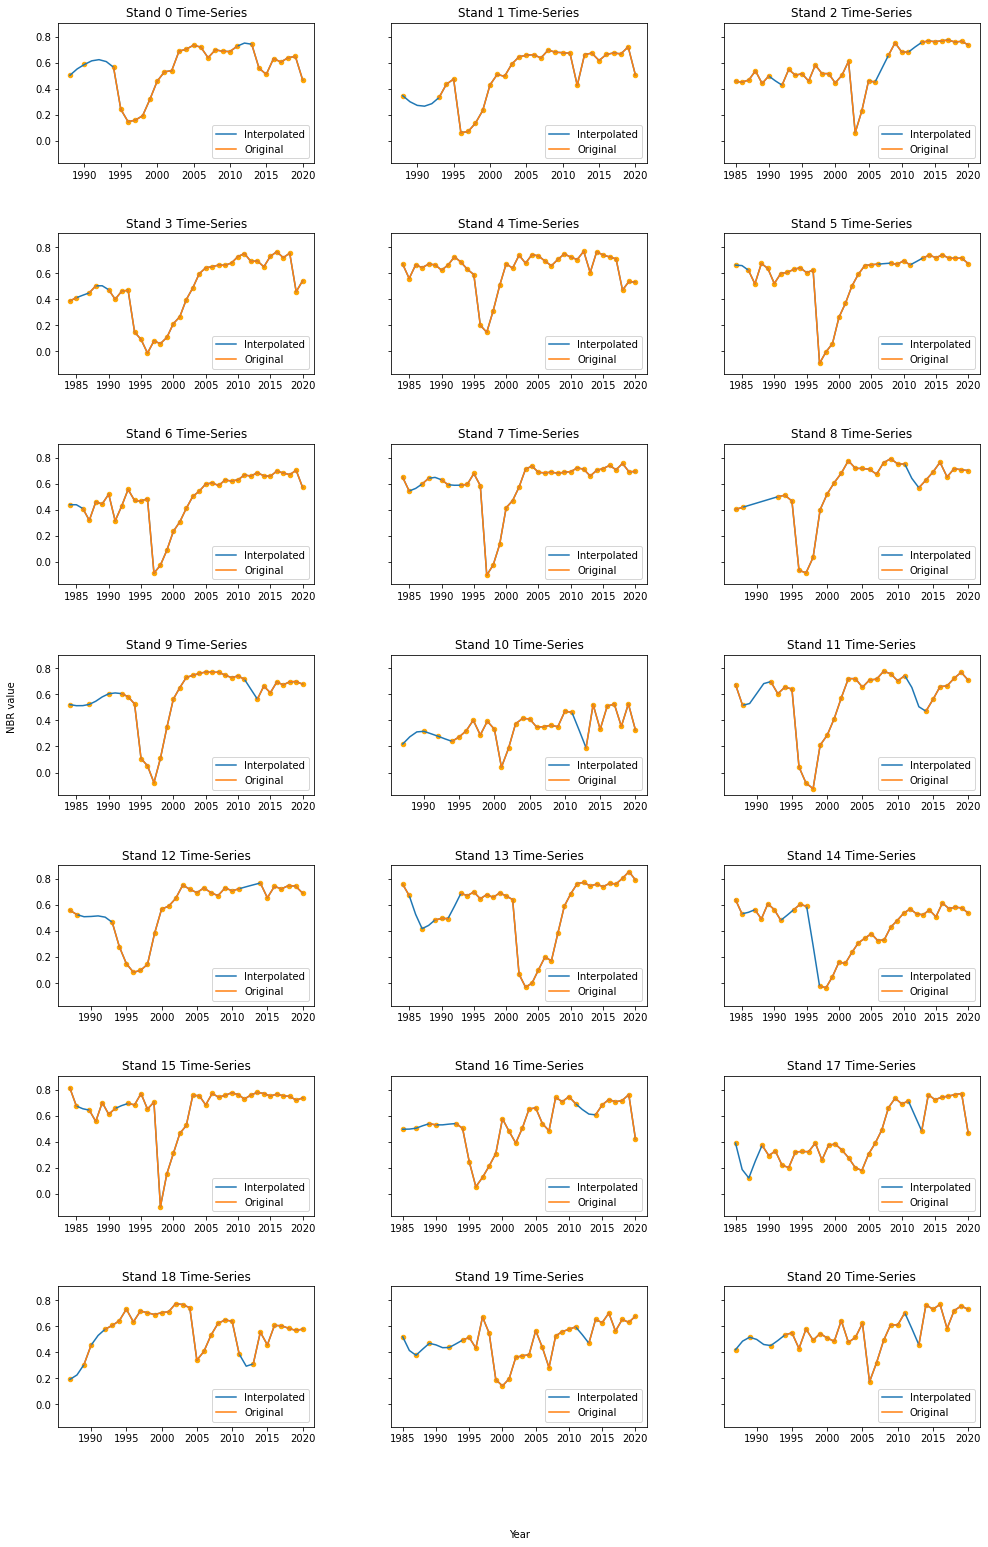

In [56]:
%matplotlib inline
import scipy as sp
import scipy.signal as scisig

# interpolation of null values
plotDF = NDVItsDF.interpolate(axis = 'columns',method = 'akima')

# setting up for time-series plots
fig, axs = plt.subplots(7, 3, sharex=False, sharey=True, figsize = (16,25))

for i, ax in enumerate(fig.axes):
    ax.plot(plotDF.iloc[i,].transpose(),label = "Interpolated")
    ax.plot(NDVItsDF.iloc[i,].transpose(),label = "Original")
    ax.scatter(imageYears,NDVItsDF.iloc[i,], color = 'orange',s = 20)
    ax.legend(loc='lower right')
    ax.set_title("Stand"+' '+str(i)+' '+"Time-Series")
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.3, hspace=0.5)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, (outputIndex+' '+'value'), ha='center', va='center', rotation='vertical')

In [57]:
plotDF

plotDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500_3.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')